# Project: Melanom detection and identification using the ABCD method

## Table of Contents
 <font size=4> 

1. [Introduction](#Introduction)
2. [Initial method from the moodle](##Initial-method-from-the-moodle)
3. [First improvement : remove the hairs and identify the Melanoma](#First-imporvement:-remove-the-hairs)
    1. [Hair identification](#Hair-identification)
    2. [Hair removal](#Hair-removal)
    3. [Melanoma identification](#Melanoma-identification)
    4. [Conclusion](#hairconclusion)
4. [ABCD : rules implementation and improvement](#ABCD:-rules-implementation-and-improvement)
    1. [Rule A : Assymetry](#Rule-A:-assymetry)
    2. [Rule D : Diameter](#Rule-D:-diameter)
    3. [Rule C : Color](#Rule-C:-color)
    4. [Rule B : Border](#Rule-B:-border)
    5. [Rules combinations](#Rules-combinations)
5. [Conclusion](#Conclusion)
6. [References](#References)


</font> 

## 1. Introduction <a class="anchor" id="Introduction"></a>
Melanoma is a cancer of the skin or mucous membranes. There are several types of melanomas, including basal, squamous, and cutaneous melanomas. The melanoma is a malignant tumor that is formed by the cells of the skin. Even if it can be cured if detected early, most patients oversee its existence. In fact, most patients with melanomas are not even aware of the existence of the disease, and cannot differentiate between benign and malignant melanomas.

Its initial site is the skin in the vast majority of cases.
However, there are also melanomas of the eye, of the mucous membranes, and even more rarely of the internal organs.

Premature detection of melanomas is a common problem in the early stages of the disease. Early detection of the mealanoma is crucial for the survival of the patient. That's why we have put a lot of efforts to develop and improve existing method for the detection of melanomas. We believe that our method is effective and robust since it involves a combination of different approaches.

We hope you will enjoy going through this notebook !

In [3]:
# imports the required packages
from skimage.io import imread
import seaborn as sns
import os
import math
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu, difference_of_gaussians, gaussian
import skimage
from skimage.color import rgb2gray, rgb2hsv, rgb2lab
from skimage.transform import rotate
from skimage.measure import regionprops, label
from skimage.morphology import dilation, binary_closing, disk, octagon, erosion, binary_opening
from scipy.ndimage.morphology import binary_fill_holes
from skimage import data
from skimage.measure import label, regionprops, find_contours
from scipy import interpolate
from tqdm import tqdm
import pandas as pd


## 2. Initial method from the Moodle  <a class="anchor" id="Initial-method-from-the-moodle"></a>
In this method, we will apply a naive method that is described in the highlights of the project. This method will only include the BC rule without the AD one. The latter will be explored in the improvements section. <br/>
The method consists of the following steps:
1. Convert the image to grayscale
2. Apply the otsu thresholding to segment the image.
3. Apply the connected components algorithm to find the biggest connected component.
4. Compute the solidity of the biggest connected component to estimate the B criteria score from the ABCD rule.
5. Calculate the sum of the standard deviations of each band to estimate the variegated color (C criteria).
6. The subject is considered as melanoma if B < 0.95 and C > 100 (adjustable).

In [4]:
def evaluate_melanoma(image_path, B_LIMIT=0.95, C_LIMIT=100,  display=False, printing=False):
    """
    [Base function to evaluate the image for melanoma].
        It is not very efficient, about 48% of similarity with dermatologists results.

    Args:
        image_path ([string]): [path to the image]
        display (bool, optional): [chose to display image on figure or not]. Defaults to False.
        printing (bool, optional): [choose to print the results on the console or not]. Defaults to False.

    Returns:
        [tuple(solidity : float, global_std : float, predict_melamona : float)]: [criteria B and C]
    """

    # Grab the first image
    original = imread(image_path)
    # Convert to grayscale then apply an Otsu thresholding
    grayscale = rgb2gray(original)
    # s = grayscale.shape[0]
    thresh_otsu_value = threshold_otsu(grayscale)
    thresholded_image = grayscale < thresh_otsu_value

    # display the thresholded if requested
    if display:
        plt.figure("original")
        plt.imshow(grayscale, cmap="gray")
        plt.figure("otsu")
        plt.imshow(thresholded_image, cmap="gray")

    # Computes the regions detected on the image
    label_img = label(thresholded_image)
    regions = regionprops(label_img)

    # extract the bounding box coordinates, areas, solidity
    areas = [prop.area for prop in regions]
    bboxs = [prop.bbox for prop in regions]
    solidities = [prop.solidity for prop in regions]

    # Sort the areas in ascending order
    areas_sort = np.sort(areas)
    # Get the index of the largest area
    index = areas.index(areas_sort[-1])

    # Get the bounding box of the largest area and its solidity and its area
    bbox = bboxs[index]
    area = areas[index]
    solidity = solidities[index]

    # Get the width and height of the bounding box
    minr, minc, maxr, maxc = bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)

    # display the bouding box of the region if requested
    if display:
        plt.figure("region")
        plt.imshow(thresholded_image, cmap="gray")
        plt.plot(bx, by, '-b', linewidth=2.5)
        plt.show()

    # computes the standard deviation of the image for each channel and sums up
    R_std = np.std(original[:, :, 0])
    G_std = np.std(original[:, :, 1])
    B_std = np.std(original[:, :, 2])

    global_std = R_std + G_std + B_std

    # predicts if the image is a melanoma or not
    predicted_melanoma = False

    # criteria for melanoma : C > 100 and B < 0.95
    if solidity < B_LIMIT and global_std > C_LIMIT:
        predicted_melanoma = True

    # print the informations if requested
    if printing:
        print(
            f'Max region properties : \n-solidity : {solidity} \n-area = {area} \n-prediction = {predicted_melanoma}')

    return solidity, global_std, predicted_melanoma


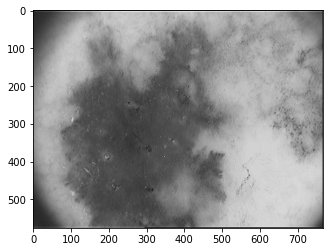

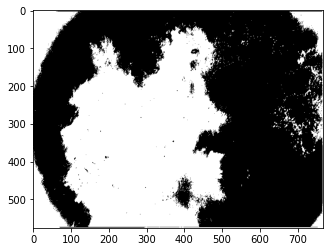

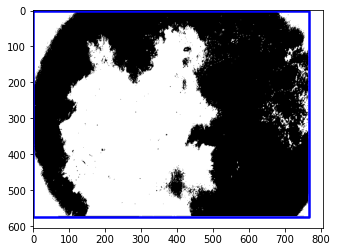

Max region properties : 
-solidity : 0.4282271773726852 
-area = 189434 
-prediction = True


In [5]:
# Test the function on a sample image 
_ = evaluate_melanoma("ph2-dataset/IMD420.bmp", display=True, printing=True)

Since we have now a method that works on a single image, we will now apply it to the whole dataset and mesure the accuracy of the method.
1. Load the all dataset through *os.listdir* function.
2. Compute the all dataset (if the boolean constant is set to True). Then save it to a *.csv* file
3. Load the result from the dataset with *pandas dataframe* and compare it to the actual results.
4. Prints the results : true positives, false positives, false negatives and the accuracy.


In [6]:
# Re-evaluate the melanoma on the whole dataset
COMPUTE_DATASET = False


# Verify that the dateset is present
try:
    files_list = os.listdir("ph2-dataset")
except Exception as e:
    print("Error loading the dataset: ", e)
    raise ValueError('dataset not found')

if COMPUTE_DATASET:
    d = {}
    for image in files_list:
        # Add to the dictionnary the result of its evaluation
        d[image] = evaluate_melanoma("ph2-dataset/"+image)[2]

    # Create a dataframe from the dictionnary to save it
    df = pd.DataFrame(d.items(), columns=['Image', 'Type'])
    df.to_csv("output.csv")

else:  # Read results directly from the csv file without computing them
    try:
        df = pd.read_csv("output.csv")
    except Exception as e:
        print("Error loading the computed result: ", e)

# Get the ground truth of the dataset from the csv file generated by the dermatologists
ground_truth = pd.read_csv("PH2_dataset.csv")

# Totals of positives and negatives on the dataset
POSITIVES = 40
NEGATIVES = 160

# Counters of true positives and true negatives
success_pos = 0
success_neg = 0


for i, element in enumerate(ground_truth["Melanoma"]):
    # if predcting the melanoma is correct
    if (element == "X" and df["Type"][i]):
        success_pos += 1
    if (element != "X" and not df["Type"][i]):
        success_neg += 1


print(f"true positives : {success_pos} ; ratio = {success_pos/POSITIVES}")
print(f"true negatives : {success_neg} ; ratio = {success_neg/NEGATIVES}")

accuracy = 0.5 * (success_pos/POSITIVES + success_neg/NEGATIVES)
print(f"Global evaluation (accuracy) : {accuracy}")


true positives : 8 ; ratio = 0.2
true negatives : 122 ; ratio = 0.7625
Global evaluation (accuracy) : 0.48124999999999996


For the dataset evaluation we decided to use the following formula :
$$\text{accuracy} = 0.5 \left( \frac{TP}{P} + \frac{TN}{N} \right) $$
To be more precised this accuracy is often called the balanced accuracy. It is used in order to compensate the skewed datasets. [4]


However other formulas can be used to evaluate the performances of a dataset such as the metric described in the following code shows.

Accuracy (not balanced): 0.65 


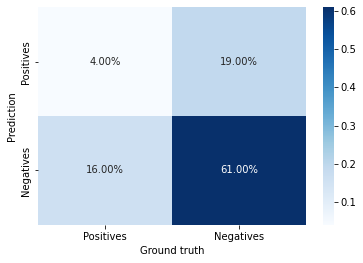

In [7]:
cf_matrix = np.array([[success_pos, NEGATIVES - success_neg],
                     [POSITIVES - success_pos, success_neg]])
print("Accuracy (not balanced): %.2f " %
      ((cf_matrix[0, 0]+cf_matrix[1, 1])/np.sum(cf_matrix)))
hm = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,
                 fmt='.2%', cmap='Blues')

_ = hm.set_xlabel('Ground truth')
_ = hm.set_ylabel('Prediction')
_ = hm.set_xticklabels(['Positives', 'Negatives'])
_ = hm.set_yticklabels(['Positives', 'Negatives'])


As we can see this first approach is not very good and has to be optimized.

Therefore, we will be using severals methods to improve the results :
1. Remove the hairs
2. Work with a different color space more adapted to human perception
3. Improve B and C criteria and use B and D rules

## 3. First improvement : remove the hairs. <a class="anchor" id="First-imporvement:-remove-the-hairs"></a>
In this removal we used 2 differents approaches : 
1. Using the Hair removal method described in the article 1.
2. Then Remove the hairs
3. Using morphological operations to identify the melanoma. 

### 3.1. First approach : Identify the hairs <a class="anchor" id="Hair-identification"></a>
In this approach we will use the method described in the paper 1 with the following diagram from their paper explaining its idea. <br/>
<img src="abbas.png" alt="drawing" width="600"/>
1. Load the image and crop it to delete the borders because some images have artefacts on their borders. 
2. Apply a Difference of Gaussian (DoG) to the image. 
The idea with this  DoG is being able to detect black hairs as well as white ones and hairs on the melanoma. 
3. Then we will threshold to the image. This step of segmentation is crucial to the method. So the thresholding parameter is done determined experimentally. 
4. Remove small and circular objects as it is done in the paper:
    - First we will remove too small objects because we cannot calculate their regions properties
    - Then we will remove the circular objects because they are probably not hairs portions (hairs portion are more likely to be long and thin). This is done by calculating the ratio between its ellipse major axis and its ellipse minor axis.
5. Dilate the object to connect the hairs portion together. This step requires the previous one imperatively. Indeed if not done this way, the segmentation dots will expand and connect to the hairs. Then when we will be using regions to identify hairs dots will be connected to the region. 
6. Identify regions and select ones that might correspond to the hairs. For this we use severals criterias :
    - A hair can be a long and thin region (ratio between the major axis of its bounding ellipse and the minor axis). For this we based our constants some pixel measurements on the images.
    - *OR* in case of two (or more) hairs crossing each other, the region can be identified because it has a major axis long enough to be a hair, and as a very small solidity since the hairs are thin yet they occupy a large area.  

7. Finnaly we apply an erosion to the mask image to make the hairs thinner thus more closer to the original ones. In practice we chose to the same kernel as we used for the dilation to get remove the extra pixels created by this dilatation.

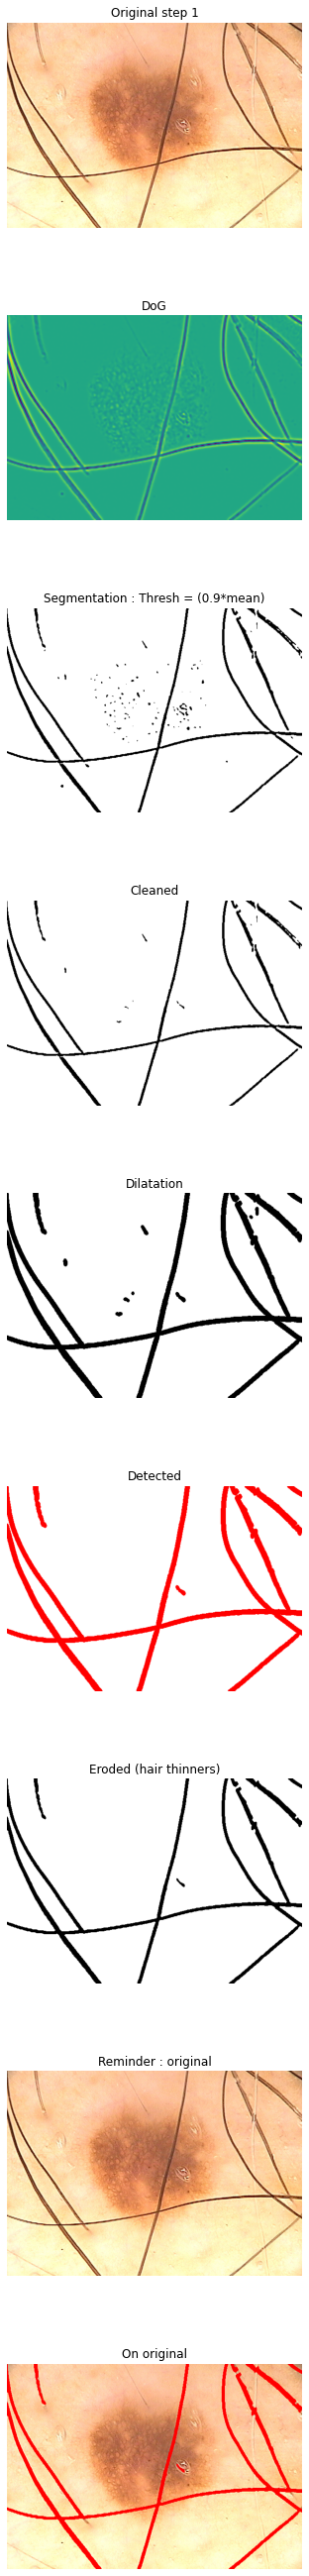

In [8]:
def identify_hairs(IMAGE_PATH, plotting=True, saving=True, **kwargs):
    """
    This function identifies the hairs
    """
    # --- PROGRAM PARAMETERS ---
    options = {
        'BORDER_SIZE': 70,  # pixels to remove from the border
        'DOG_SIGMA': 2,  # sigma passed to the dog gaussian
        'THRESH_FACTOR': 0.9,  # threshold factor
        'REMOVAL_REGION_SIZE': 100,  # Size of small regions to remove
        'REMOVAL_CIRC_RATIO': 0.35,  # Circularity ratio of smalls regions to remove
        'DILATATION_SIZE': 3,  # Size of dilation to connect lines
        # Type of connectivity for regions to connect 0 (little), 1 (big)
        'REGION_CONNECTIVITY': 1,
        'HAIRS_LENGTH': 30,  # minimum length of a hairs in pixels
        'HAIRS_WIDTH_LENGTH_RATIO': 0.4,  # hairs width / length
        'HAIRS_MAX_SOLIDITY': 0.35,  # maximum solidity of a hairs crossing
        'CLOSING_SIZE': 10,  # Size of closing to fill gaps within hairs
        'EROSION_SIZE': 2,  # Size equal to the size of erosion to make hairs thinner
    }
    options.update(kwargs)
    # Apply kwargs to options
    BORDER_SIZE = options['BORDER_SIZE']
    DOG_SIGMA = options['DOG_SIGMA']
    THRESH_FACTOR = options['THRESH_FACTOR']
    REMOVAL_REGION_SIZE = options['REMOVAL_REGION_SIZE']
    REMOVAL_CIRC_RATIO = options['REMOVAL_CIRC_RATIO']
    DILATATION_SIZE = options['DILATATION_SIZE']
    REGION_CONNECTIVITY = options['REGION_CONNECTIVITY']
    HAIRS_LENGTH = options['HAIRS_LENGTH']
    HAIRS_WIDTH_LENGTH_RATIO = options['HAIRS_WIDTH_LENGTH_RATIO']
    HAIRS_MAX_SOLIDITY = options['HAIRS_MAX_SOLIDITY']
    CLOSING_SIZE = options['CLOSING_SIZE']
    EROSION_SIZE = options['EROSION_SIZE']
    # --- END PROGRAM PARAMETERS ---

    # --- Figure parameters ---
    if plotting:
        fig, axs = plt.subplots(9, 1, figsize=(16/3, 16*9/3),)
        axs = axs.ravel()
        for ax in axs:
            ax.axis('off')
        # fig.tight_layout()

    # Import and preprocess image
    original = imread(IMAGE_PATH)
    # Remove borders 
    original = original[BORDER_SIZE:-BORDER_SIZE, BORDER_SIZE:-BORDER_SIZE, :]
    # Converts to HSL and keep luminance
    gray = rgb2gray(original)
    hsl_l = rgb2hsv(original)[:, :, 2]
    # Display original image
    if plotting:
        axs[0].set_title('Original step 1')
        axs[0].imshow(original)
        axs[5].set_title('Detection')
        axs[5].imshow(original)

    # --- Apply difference of gaussian ---
    dog = difference_of_gaussians(hsl_l, low_sigma=DOG_SIGMA)
    dog = (dog - np.min(dog))
    dog = dog/np.max(dog)
    if plotting:
        axs[1].set_title("DoG")
        pcm = axs[1].imshow(dog)
    # fig.colorbar(pcm, ax=axs[1])

    # --- Binary mask creation ---
    THRESH = np.mean(dog)*THRESH_FACTOR

    binary_rc = dog.copy()
    binary_rc[binary_rc < THRESH] = 0
    binary_rc[binary_rc >= THRESH] = 1
    binary_rc = 1 - binary_rc
    if plotting:
        axs[2].imshow(1-binary_rc, cmap='gray')
        axs[2].set_title("Segmentation : Thresh = (0.9*mean)")

    # --- Undesired objects removal ---
    # 1. Too small objects
    labels = label(binary_rc, connectivity=1)
    regions = regionprops(labels)
    cleaned = binary_rc.copy()
    for region in regions:
        if region.area <= 2:
            cleaned[labels == region.label] = 0
    # 2. we remove small circular objects
    labels = label(cleaned)
    regions = regionprops(labels)
    for region in regions:
        if region.area < REMOVAL_REGION_SIZE and region.minor_axis_length/region.major_axis_length > REMOVAL_CIRC_RATIO:
            cleaned[labels == region.label] = 0

    # Then display the image
    if plotting:
        axs[3].imshow(1-cleaned, cmap='gray')
        axs[3].set_title("Cleaned")

    # --- Dilation ---
    # We dilate to connect lines (without beeing annoyed by dots growing since we removed them)
    dilated = dilation(cleaned, disk(DILATATION_SIZE))
    if plotting:
        axs[4].imshow(1-dilated, cmap='gray')
        axs[4].set_title("Dilatation")

    # --- Find hairs ---
    filled = np.zeros_like(gray)
    detected = np.zeros_like(original)

    label_img = label(dilated, connectivity=REGION_CONNECTIVITY)
    regions = regionprops(label_img)

    for region in regions:
        # # Usefull code to display the contours (debugging)
        # #
        # # longueur suffisante
        # if region.major_axis_length > HAIR_LENGTH:
        #     contours = find_contours(label_img == region.label, 0.5)
        #     for c in contours:
        #         axs[4].plot(c[:, 1], c[:, 0], 'yellow')
        #         axs[4].text(region.centroid[1], region.centroid[0],
        #                     region.label, color='orange')
        #         print(f'{region.solidity=}')
        # # Suffisament ellipsoide
        # if region.minor_axis_length/region.major_axis_length < HAIR_WIDTH_LENGTH_RATIO:
        #     contours = find_contours(label_img == region.label, 0.5)
        #     for c in contours:
        #         axs[4].plot(c[:, 1], c[:, 0], 'green')
        #         axs[4].text(region.centroid[1], region.centroid[0],
        #                     region.label, color='green')

        '''
        We consider a region as a hair if :
        - it is long and thin enough
        - it is wide enough and its solidity is low (2 or more hairs crossing)
        '''

        if (region.major_axis_length > HAIRS_LENGTH and region.minor_axis_length/region.major_axis_length < HAIRS_WIDTH_LENGTH_RATIO) or (region.major_axis_length > HAIRS_LENGTH and region.solidity < HAIRS_MAX_SOLIDITY):

            for x, y in region.coords:
                filled[x, y] = 1
                detected[x][y] = [0, 255, 255]

    if plotting:
        axs[5].imshow(np.ones_like(detected)*np.max(detected)-detected)
        axs[5].set_title("Detected")

    # --- Applying a erosion to make hairs thinner ---
    eroded = erosion(filled, disk(EROSION_SIZE))

    final_mask = eroded

    if plotting:
        axs[6].imshow(np.ones_like(eroded)*np.max(eroded)-eroded, cmap='gray')
        axs[6].set_title('Eroded (hair thinners)')

    if plotting:
        if saving:
            save_path = './ph2-processed/' + \
                IMAGE_PATH.split('/')[-1][:-3] + '.jpg'
            fig.savefig(save_path, dpi=300)

        axs[7].imshow(original, cmap='gray')
        axs[7].set_title('Reminder : original')

    # --- To display on original image --- 
    on_original = original.copy()
    for x in range(len(original)):
        for y in range(len(original[0])):
            if eroded[x][y] == 1:
                on_original[x][y] = [255,0,0]
    # original*(1-eroded)*np.ones_like(original)
    if plotting :
        axs[8].imshow(on_original)
        axs[8].set_title('On original')

    return original, gray, final_mask

# --- Test the function ---
original, gray, final_mask = identify_hairs('ph2-dataset/IMD375.bmp', plotting=True, saving=True)
plt.show()

As we mentionned earlier, the segmentation is the key step of this method and this we tried to find a suitable threshold computation to get the best results. 

For this we have tried a few differents thresholding methods. We have used the Otsu, Ridler-Calvard (as used in 1), mean, and our own method. 

The main goal of this segmentation is to identify the hairs from the DoG from the background. As we can see in the figure below, the Otsu thresholding and Ridler-Calvard thresholding are very similar, and gives sometimes correct results. However their result is often inexploitable (IMD047 and IMD043) due to too much background noise. 

The mean thresholding is a not directly a good choice either because it do not separate the hairs from the background. However it repeatable that seemed to be a interesting starting point for implementing our own method.


<img src="threshold_method.png" alt="drawing"/>


Our method consists in multiplying the mean of the DoG by a constant coefficient of 0.9. This coefficient is chosen empirically and we have tested it on a few images giving good results as we can see in the following figure which changes linearly this coefficient from 1.1 to 0.7.


<img src="thresholds_constant.png" alt="drawing"/>

Our value multiplication coefficient (0.9) applied to threshold seems to be working pretty well. However, to be critical, we do not tested to apply it to Riddler-Calvard threshold or/O otsu threshold and as a future work it could be interesting to try it.

### 3.2 Hair removal method <a class="anchor" id="Hair-removal"></a>


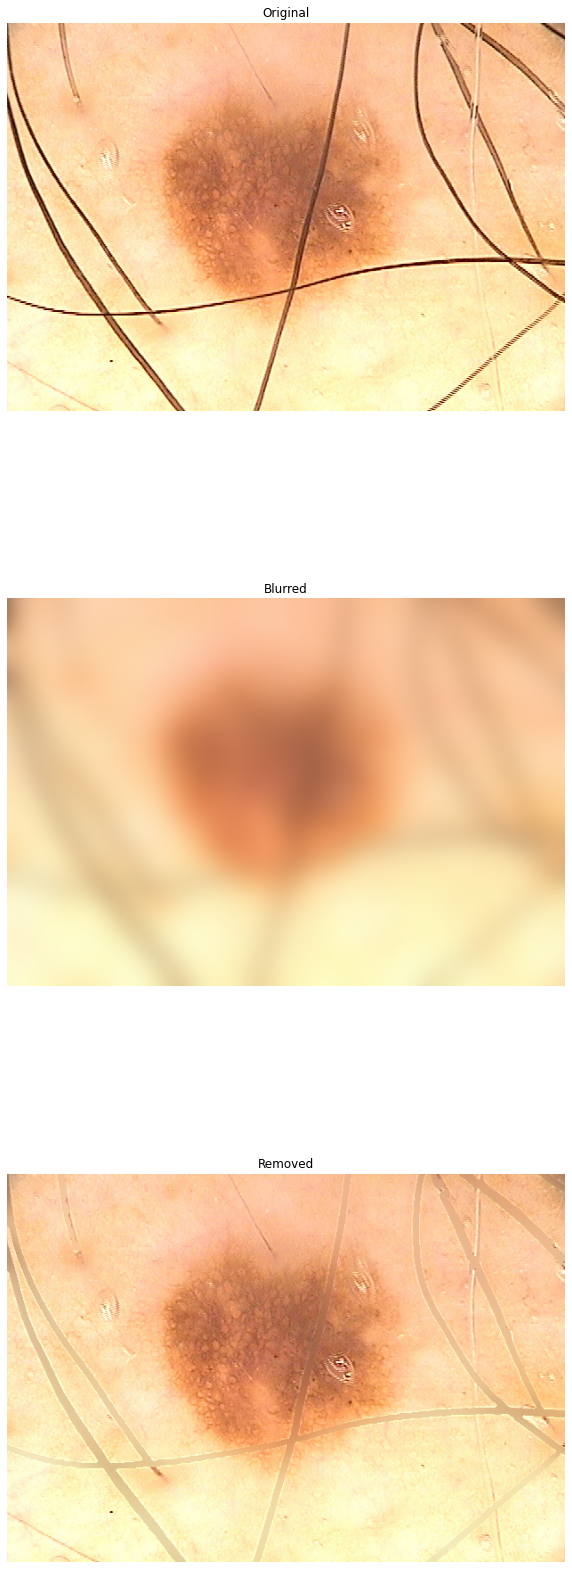

In [9]:
def remove_hair(original, mask, plotting=True, save_path=None, **kwargs):
    """
    Remove the hairs from the an image, identified in the mask

    Args:
        original ([ndarray NxMx3]): [Input color image]
        mask ([ndarray NxM np.bool]): [Input mask (binary)]
        plotting (bool, optional): [Plots or not the result removed hair image]. Defaults to True.
        save_path ([type], optional): [Saves the result plot to an image at the requested image path ]. Defaults to None = no saving.
    Returns:
        [NxMx3]: [Removed hair image]
    """    
    options = {
        'SIGMA': 15,  # based on hairs width 1approx 15 pixels
    } 
    SIGMA = options['SIGMA']

    # --- Remove the hair ---
    # We remove the hair by replacing it by the gaussian filter
    blurred = gaussian(original, sigma=options['SIGMA'], multichannel=True)
    removed = original.copy()
    for x, y in zip(*np.where(mask == 1)):
        removed[x][y] = blurred[x,y]*255

    # --- Plotting ---
    if plotting:
        fig, axs = plt.subplots(3, 1, figsize=(10, 30))
        for a in axs:
            a.axis('off')
        axs[0].imshow(original)
        axs[0].set_title("Original")
        axs[1].imshow(blurred)
        axs[1].set_title("Blurred")
        axs[2].imshow(removed)
        axs[2].set_title("Removed")
        if save_path is not None:
            fig.savefig(save_path, dpi=300)
    return removed
remove_hair(original, final_mask, plotting=True)
plt.show()


## 3.3 Second approach Melanoma identification <a class="anchor" id="Melanoma-identification"></a>
In this approach, we will use morphological operations to remove the hair.</br>
1. First, the image will be converted to grayscale.
2. Then we will apply a thresholding to the image using Otsu method.
3. After that, we will apply a morphological opening to the image. This operation is done to remove the small objects. We will also see the impact of different structuring elements.

First, let's grab the image and convert it to grayscale.

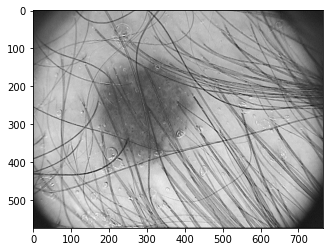

In [10]:
original_1 = imread('ph2-dataset/IMD003.bmp')
gray_1 = rgb2gray(original_1)
plt.imshow(gray_1,cmap='gray')
plt.show()

As we can see, the border of the image contains dark regions due to the camera lenses. We will remove these dark regions by cropping the image.<br/>
We seek to remove these regions so that it does not affect the thresholding. In fact, since the melanoma is dark too, we cannot easily distinguish the melanoma from the borders.<br/>
Of course, cropping the image is not the best way to do it since it can crop the subject of interest too. We will use a better approach in the next section.

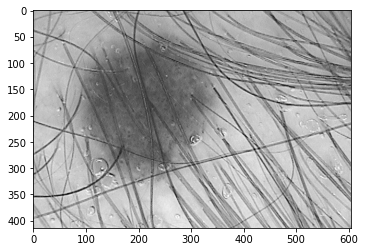

In [11]:
BORDER_SIZE = 80
original_1 = original_1[BORDER_SIZE:-BORDER_SIZE, BORDER_SIZE:-BORDER_SIZE]
gray_1 = rgb2gray(original_1)
plt.imshow(gray_1,cmap='gray')
plt.show()

Now we will apply the thresholding to the image.

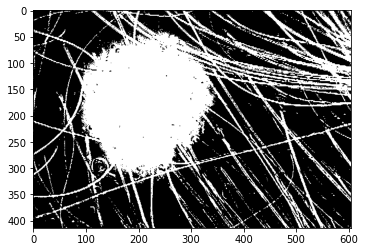

In [12]:
binary_1 = gray_1.copy()
THRESH = threshold_otsu(binary_1)
binary_1 = np.where(binary_1 > THRESH, 0, 1)
plt.imshow(binary_1, cmap='gray')
plt.show()

As we can see, after the thresholding, we still have the hairs on the image. We will remove them by applying a morphological opening.<br/>
We chose to use an opening because it removes small objects which is the case of the hairs. Also, the benefit of the opening is that it conserves the size of the object which is very important in our case since we do not want to alter the size of the subject of study.<br/>
We will first try a disk with different sizes as the structuring element.

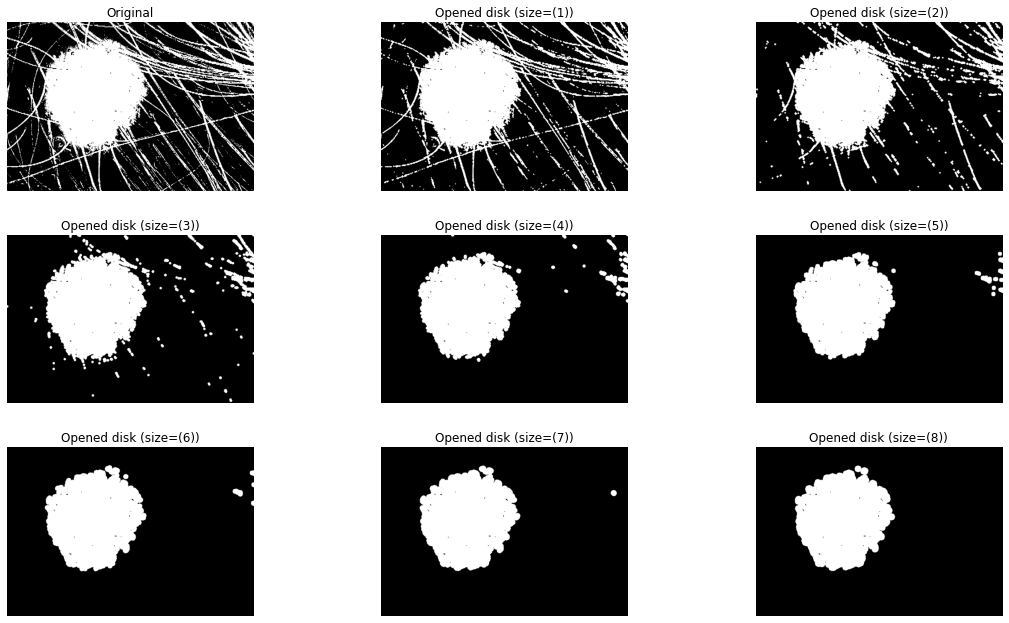

In [13]:
#plots
fig, axs  = plt.subplots(3,3, figsize=(16, 9))
axs = axs.ravel()
axs[0].imshow(binary_1, cmap='gray')
axs[0].set_title('Original')
# different structuring element sizes
selem_sizes = np.arange(1, 9)
# loop over the sizes and compute tthe opening
for i, size in enumerate(selem_sizes):
    el = disk(size)
    op = binary_opening(binary_1, selem=el)
    axs[i+1].imshow(op, cmap='gray')
    axs[i+1].set_title('Opened disk (size=(%i))'%(size))
fig.tight_layout()
for ax in axs:
    ax.axis('off')

plt.show()

As we can see, the hairs are completely removed after using a disk of radius 8. <br/>
We also did the same operation but using an octagon as a structuring element, and also for different sizes. **The size of the horizontal and vertical sides and the height of the slanted sides will be the same.**<br/> 
![hair_removal_octagon](hair_removal_octagon.png)<br/>
We can see the impact of the different sizes of the structuring element.<br/>
For the octagon, we only need to use a size of 6 to completely remove the hairs. So in order to minimize the impact of the opening on the studied subject, we will use an octagon of size (6,6).<br/>
Also, we will perform a closing operation to fill the holes created by the opening and to weld the close shapes together.

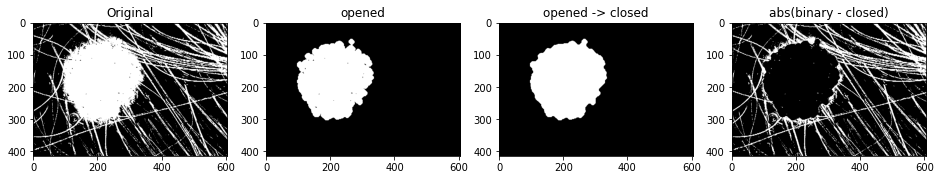

In [14]:
selem = octagon(6, 6)#structuring element
op = binary_opening(binary_1, selem=selem)#opening
cl = binary_closing(op, selem=selem)#closing
fig, axs  = plt.subplots(1,4, figsize=(16, 9))
axs = axs.ravel()
axs[0].imshow(binary_1, cmap='gray')
axs[0].set_title('Original')
axs[1].imshow(op, cmap='gray')
axs[1].set_title('opened')
axs[2].imshow(cl, cmap='gray')
axs[2].set_title('opened -> closed')
axs[3].imshow(np.abs(cl - binary_1), cmap='gray')
axs[3].set_title('abs(binary - closed)')
plt.show()

As we can see, when doing the morphological operations, the lesion shape is slightly modified (see figure 4 in the plot above), especially the borders. This latters are in fact rounded. In order to solve this problem, we will correct the image using the following algorithm :<br/>
1. We will compute the contours of the lesion.
2. We will apply a dilation to the contours.
3. We will multiply the result by the absolute value of the difference between the (opened->closed) image and the original binary image.
4. We will apply a closing operation.
5. We will fill the holes inside the closed image.

By doing this, we will capture the information of the borders of the lesion from the original image.

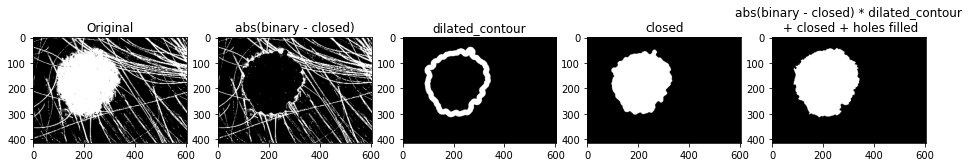

In [15]:
def filter_contours_by_area(binary_image):
    """[Clean the image removing small regions in order to keep only the melanoma]

    Args:
        image ([ndarray NxM np.bool]): [description]

    Returns:
        [ndarray NxM np.bool]: [the binary mask filtered by area]
    """    
    # --- Identify the regions in the mask image ---
    labels = label(binary_image, connectivity=1)
    regions = regionprops(labels)

    # --- keep the region with the biggest area ---
    area_max = max([r.area for r in regions])
    regions = [r for r in regions if r.area > area_max*0.2]

    # --- Create a new mask image containing only the biggest region ---
    cleaned = np.zeros_like(binary_image)
    for r in regions:
        for x, y in r.coords:
            cleaned[x, y] = 1
        
    return cleaned

#function to get the columun of matrix by index

def column(matrix, i):
    return [row[i] for row in matrix]
contours = find_contours(cl)

#build the contour
im = np.zeros_like(binary_1)
for x,y in contours[0]:
    im[int(x),int(y)] = 1
#dilate the contour
dilated_contour = dilation(im, disk(10))
#multiply the contour with the original image
corrected = np.abs(cl - binary_1) * dilated_contour
final_image = corrected + cl
#filter small elements
final_image = filter_contours_by_area(final_image)
#saturate at image at 1
final_image = np.where(final_image >= 1, 1, 0)
#closing
final_image = binary_closing(final_image, disk(3))
#fill holes inside the lesion
final_image = binary_fill_holes(final_image)

fig, axs  = plt.subplots(1,5, figsize=(16, 9))
axs = axs.ravel()

axs[0].imshow(binary_1, cmap='gray')
axs[0].set_title('Original')
axs[1].imshow(np.abs(cl - binary_1), cmap='gray')
axs[1].set_title('abs(binary - closed)')
axs[2].imshow(dilated_contour, cmap='gray')
axs[2].set_title('dilated_contour')
axs[3].imshow(cl, cmap='gray')
axs[3].set_title('closed')
axs[4].imshow(final_image, cmap='gray')
axs[4].set_title('abs(binary - closed) * dilated_contour\n + closed + holes filled')

plt.show()



We can clearly see that the borders of the lesion are improved. In fact they are very similar to the borders of the original lesion.

For ease of use we are going to wrap this 2nd method as a function.

In [16]:
def melonoma_identification(image, **kwargs):
    """[summary]

    Args:
        image_path ([string]): [path to the image]

    Returns:
        [type]: [description]
    """    

    # --- Loading the options ---
    options = {
        'SELEM_SIZE': 6,
        'DILATATION_SIZE': 6,
    }
    options.update(kwargs)
    SELEM_SIZE = options['SELEM_SIZE']
    DILATATION_SIZE = options['DILATATION_SIZE']
    # --- end loading options---

    # --- Loading the image and cropping it ---
    original = image
    #BORDER_SIZE = 70
    #original = original[BORDER_SIZE:-BORDER_SIZE, BORDER_SIZE:-BORDER_SIZE, :]
    #original = original[:, BORDER_SIZE:-BORDER_SIZE, :]
    # Converts to grayscale
    gray = rgb2gray(original)
    
    # --- Thresholding ---
    binary = gray.copy()
    THRESH = threshold_otsu(binary)
    binary = np.where(binary > THRESH, 0, 1)

    # --- Morphological Operations ---
    selem = octagon(SELEM_SIZE, SELEM_SIZE)
    op = binary_opening(binary, selem=selem)
    cl = binary_closing(op, selem=selem)

    # --- Find the countours create a mask with it ---
    contours = find_contours(cl)
    im = np.zeros_like(binary)
    for x,y in contours[0]:
        im[int(x),int(y)] = 1

    # --- Operations ---
    
    dilated_contour = dilation(im, disk(DILATATION_SIZE))
    corrected = np.abs(cl - binary) * dilated_contour
    final_image = corrected + cl
    final_image = filter_contours_by_area(final_image)
    final_image = np.where(final_image >= 1, 1, 0)
    final_image = binary_closing(final_image, disk(3))
    final_image = binary_fill_holes(final_image)
    
    return final_image

### 3.4. Conclusion of hair removal <a class="anchor" id="hairconclusion"></a>


In conclusion, those 2 methods use different approaches. The first one focuses on hair identification whereas the second one focuses on melanoma identification. They each have advantages and drawbacks. First one can identify hairs on melanoma and erase them however it does not completely remove all the hairs. On the other hand the second method, can remove all the hairs on outside melanoma areas, but it cannot remove hairs on the melanoma. 


These two methods can complement each other, using the second one first can remove the hairs on the outside of the melanoma then we can use the first one to try to remove the hairs on the inside of the melanoma.

We can now use this combination of the two methods to pre-process the whole dataset.

In [41]:
RECOMPUTE = True
if RECOMPUTE:
    # --- Loop through all the images applying both previous methods ---
    for i, image in enumerate(tqdm(os.listdir("ph2-dataset"))):
        
        original, gray, final_mask = identify_hairs(os.path.join("ph2-dataset", image), plotting=False, save=False)
        removed = remove_hair(original, final_mask, plotting=False)
        processed_image = melonoma_identification(removed)

        final = removed.copy()
        R,G,B = removed[:,:,0], removed[:,:,1], removed[:,:,2]
        final[:,:,0] = processed_image * R
        final[:,:,1] = processed_image * G
        final[:,:,2] = processed_image * B

        skimage.io.imsave(f"ph2-processed/{image}", final)

100%|██████████| 200/200 [03:41<00:00,  1.11s/it]


##  4. Second Improvement ABCD Rules implementation and improvement <a class="anchor" id="ABCD:-rules-implementation-and-improvement"></a>
### Introduction

### 4.1 Rule A : Asymmetry <a class="anchor" id="Rule-A:-assymetry"></a>
#### Color assymetry
For the A rule we have been following the method used in the paper [2]. This method on the following steps :
1. Convert the image to L\*a\*b color space because it is one of the most suitable to mimic the human vision color perception.
2. Identify the melanoma, its axis and its orientation
3. Rotate the image to align the axis with the x-axis and y-axis of the image. It is a comfortable transformation that makes working with the melanoma asymmetry easier.
4. Then divide the image into 4 quadrants. 
5. For each quadrant, groups of 20x20 pixels are formed and the mean of color for each group is computed. 
    - We did not considered this step and worked directly on the quadrant. 
6. Compute the euclidian distance between symetric groups of pixels.
7. Summ all the distances to obtain a score. The higher the score is the more likely the image is a melanoma.
#### Luminance assymetry
For this rule we have been continuing to follow the method used in the paper [2]. This is the same method as in the last rule but we have used the luminance instead of the color.
#### Area assymetry
For this step also we have been following the method used in the paper [2]. This can be implemented on the the color assymetry step. It simply consists in summing the euclidian distance between the areas of the 4 quadrants one to the other.

In [18]:
def centree_reduite(X):
    Y = (X-np.mean(X))/np.std(X)
    return Y, np.mean(X), np.std(X)


def compute_AD_criteria(IMAGE_PATH):
    """[Compute A criterias and D criterias adapted from article 2]


    Args:
        IMAGE_PATH ([string]): [path to the image]

    Returns:
        [float]: [A criteria]
    """
    # --- Load image and extract basic informations ---
    original = imread(IMAGE_PATH)
    gray = rgb2gray(original)
    mask = np.where(gray > 0, 1, 0)

    # --- Identify the regions ---
    # Grabs the biggest region and extract its angle and center
    labels = label(mask)
    props = regionprops(labels)
    p = max(props, key=lambda x: x.area)
    y0, x0 = p.centroid
    orientation = p.orientation

    # --- Convert colorspace to L*a*b as in the article ---
    lab = rgb2lab(original)

    # --- Rotate the image to align the ellipse on x, y axis ---
    rot_lab = rotate(lab, -p.orientation*180/np.pi,
                     center=(x0, y0), resize=True)
    rot_original = rotate(original, -p.orientation*180 /
                          np.pi, center=(x0, y0), resize=True)
    rot_gray = rgb2gray(rot_original)
    rot_mask = np.where(rot_gray > 0, 1, 0)

    # --- Grab the new region and its properties ---
    labels = label(rot_mask)
    props = regionprops(labels)
    p = max(props, key=lambda x: x.area)
    total_area = p.area
    x0, y0 = p.centroid
    minor_axis = p.minor_axis_length
    major_axis = p.major_axis_length
    # --- Compute the D criteria ---
    D_approximate_diameter = 0.5 * (minor_axis + major_axis)

    # --- Divise the image in 4 corners ---
    # Instead of following the article defining 20x20 pixels zones, for ease reasons, we considered only one region per corner
    tl, br, tr, bl = rot_lab[:int(x0), :int(y0), :], rot_lab[int(x0):, :int(
        y0), :], rot_lab[:int(x0), int(y0):, :], rot_lab[int(x0):, int(y0):, :]
    corners = [tl, tr, br, bl]

    # --- Get each corner mean for each canal to conpute their euclidan distance ---
    means = []
    areas = []
    for i in range(4):
        Lchannel = corners[i][:, :, 0]
        achannel = corners[i][:, :, 1]
        bchannel = corners[i][:, :, 2]
        L = np.sum(Lchannel)/np.count_nonzero(Lchannel)
        a = np.sum(achannel)/np.count_nonzero(achannel)
        b = np.sum(bchannel)/np.count_nonzero(bchannel)

        # is colored matrice = 0 if not colored or 1 if colored
        is_colored = np.logical_or(np.logical_or(np.not_equal(
            Lchannel, 0), np.not_equal(achannel, 0)), np.not_equal(bchannel, 0))
        areas.append(np.sum(is_colored))
        means.append(np.array([L, a, b]))

    # --- Compute the euclidian distance between each corner to evaluate the asymmetry (for each color, luminance and area) ---
    def euclidian_distance(a, b):
        return np.sqrt(np.sum((a-b)**2))

    A_criteria_color = euclidian_distance(means[0], means[1]) + euclidian_distance(means[0], means[2]) + euclidian_distance(
        means[0], means[3]) + euclidian_distance(means[1], means[2]) + euclidian_distance(means[1], means[3]) + euclidian_distance(means[2], means[3])
    A_criteria_luminance = euclidian_distance(means[0][0], means[1][0]) + euclidian_distance(means[0][0], means[2][0]) + euclidian_distance(
        means[0][0], means[3][0]) + euclidian_distance(means[1][0], means[2][0]) + euclidian_distance(means[1][0], means[3][0]) + euclidian_distance(means[2][0], means[3][0])
    A_criteria_area = euclidian_distance(areas[0], areas[1]) + euclidian_distance(areas[0], areas[2]) + euclidian_distance(
        areas[0], areas[3]) + euclidian_distance(areas[1], areas[2]) + euclidian_distance(areas[1], areas[3]) + euclidian_distance(areas[2], areas[3])

    # Returns each criteria
    return A_criteria_color, A_criteria_luminance, A_criteria_area, D_approximate_diameter


### 4.2 Rule D : Diameter <a class="anchor" id="Rule-D:-diameter"></a>
For the diameter we have chosen to caracterise the melanoma by the diameter of the ellipse that fits the lesion. Then to consider the diameter of the lesion we have used the following formula :
$$ D = \frac{\text{ellipse\_major\_axis\_length} + \text{ellipse\_minor\_axis\_length} }{2}$$

Other formulas could have been used to compute the diameter however we have chosen to use this one because it is the most simple and intuitive and we did not have time to implement the testing of other formulas :
$$D = \sqrt{\frac{4S}{\pi}}$$
$$D = \frac{P}{D}$$
With the first one relying on the area of the lesion, the second one relying on the perimeter of the lesion.

One could have notice that we already introduced this formula in the previous code block, with the following code :
>     # --- Grab the new region and its properties ---
>     ...
>     minor_axis = p.minor_axis_length
>     major_axis = p.major_axis_length
>     # --- Compute the D criteria ---
>     D_approximate_diameter = 0.5 * (minor_axis + major_axis)
>     ... 
>     return ..., D_approximate_diameter

### 4.3 Rule B : Border <a class="anchor" id="Rule-B:-border"></a>

For the B rule we will first implement the method used in the paper [2]. This method on the following steps :
1. The lesion is first rotated so that the major axis is aligned with the x-axis.
2. Then the lesion is divided into 8 octants.
3. for each octant, we compute the cubic spline interpolation of the sub contour.
4. We will then compute the fitting error between the sub contour and the approximation function. The bigger the error, the irregular the contour.
5. If the error is bigger than $0.05\times size(contour)$, we will consider the contour irregular and the lesion is a melanoma.

We find that that this method is not very performant. In fact, when doing the interpolation, we tend sometimes to overfit the data of the sub-contour. Thus, the fitting error will be very small even if the contour is irregular. <br/>

Let's try with an example.<br/>

First the image is feeded to the function that will perform the pre-processing (melanoma_identification).

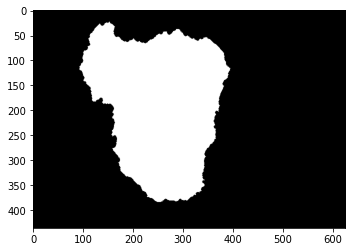

In [19]:
original, gray, final_mask = identify_hairs("ph2-dataset/IMD075.bmp", plotting=False, save=False)
removed = remove_hair(original, final_mask, plotting=False)
processed_image = melonoma_identification(removed)
plt.imshow(processed_image, cmap="gray")
plt.show()

Then the image is rotated.

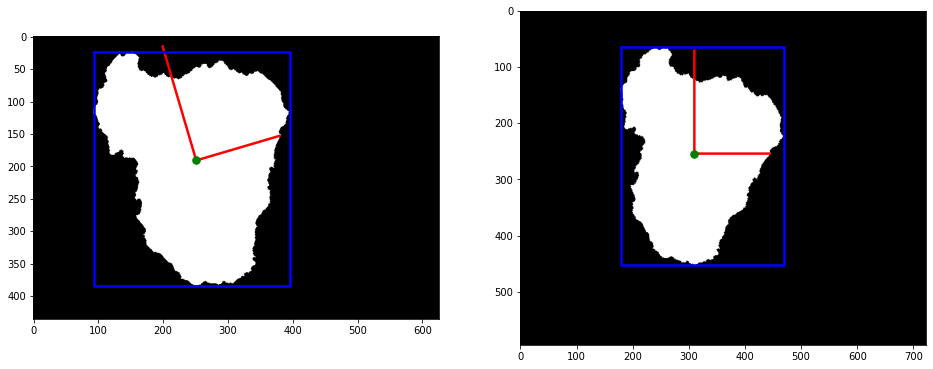

In [20]:
label_img = label(processed_image)
regions = regionprops(label_img)
fig, axs = plt.subplots(1, 2, figsize=(16, 9))
axs = axs.ravel()

props = regions[0]

y0, x0 = props.centroid
orientation = props.orientation
#rotate lesion and resize
rot = rotate(processed_image, ( - orientation) * 180/np.pi, center=(x0, y0) , resize=True)
#plot major and minor axis
x1 = x0 + math.cos(orientation) * 0.5 * props.minor_axis_length
y1 = y0 - math.sin(orientation) * 0.5 * props.minor_axis_length
x2 = x0 - math.sin(orientation) * 0.5 * props.major_axis_length
y2 = y0 - math.cos(orientation) * 0.5 * props.major_axis_length

axs[0].plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
axs[0].plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
axs[0].plot(x0, y0, '.g', markersize=15)
# bounding box
minr, minc, maxr, maxc = props.bbox
bx = (minc, maxc, maxc, minc, minc)
by = (minr, minr, maxr, maxr, minr)
axs[0].plot(bx, by, '-b', linewidth=2.5)
axs[0].imshow(processed_image, cmap=plt.cm.gray)

label_rot = label(rot)
regions = regionprops(label_rot)
props = regions[0]
y0, x0 = props.centroid
orientation = props.orientation
axs[1].imshow(rot, cmap=plt.cm.gray)
x1 = x0 + math.cos(orientation) * 0.5 * props.minor_axis_length
y1 = y0 - math.sin(orientation) * 0.5 * props.minor_axis_length
x2 = x0 - math.sin(orientation) * 0.5 * props.major_axis_length
y2 = y0 - math.cos(orientation) * 0.5 * props.major_axis_length

axs[1].plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
axs[1].plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
axs[1].plot(x0, y0, '.g', markersize=15)

minr, minc, maxr, maxc = props.bbox
bx = (minc, maxc, maxc, minc, minc)
by = (minr, minr, maxr, maxr, minr)
axs[1].plot(bx, by, '-b', linewidth=2.5)
axs[1].imshow(rot, cmap=plt.cm.gray)

plt.show()

The contour is then divergence into 8 octants. To do that, we will simply divide the contour array into 8 parts.

Then we will compute the cubic spline interpolation of the sub contour.

in the sequel, we give an example of one sub contour.

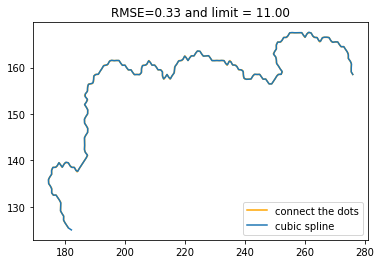

In [21]:
# compute contours
contours = find_contours(processed_image)[0]

#divide contours into 8 groups
t = len(contours)//8
#get one contour sample
c = contours[1*t:2*t]
ta = len(c)
data = np.array(c)

#interpolate contours
x,y = zip(*data)
data1 = [data[i] for i in range(len(data)) if i % (1) == 0]
x1,y1 = zip(*data1)

tck,u = interpolate.splprep([x1, y1], s=0, k = 3)
unew = np.arange(0, 1.01, 1.01/ta)
out = interpolate.splev(unew, tck)
# plot interpolated contours
plt.plot(x, y, 'orange', out[0], out[1])
plt.legend(['connect the dots', 'cubic spline'])
# calculate errors
absError = out[1] - y
SE = np.square(absError)
MSE = np.mean(SE)
RMSE = np.sqrt(MSE)
plt.title("RMSE=%.2f and limit = %.2f"%(RMSE,0.05*ta))
n=8
#axs[0].scatter(column(contours,0), column(contours,1))
#for i in range(n):
#    axs[i+1].scatter(column(contours[i*t:(i+1)*t],0), column(contours[i*t:(i+1)*t],1))
plt.show()

As we can see, even if the contour is irregular, the fitting error is very small. We can also try to reduce the number of the sub contour pixels by taking one pixel every $10$ pixels to avoid the overfitting. But we consider that this is not very robust and will depend on the lesion.<br/>
Therefore, for the ABCD rule, we won't use this method.

We will now implement the method used in the paper [3] for the B rule. This one is simple and will be used to evaluate the lesion. The method consists in calculating an index $I$ called the irregularity index. which is equal to:
$$I =  \frac{P^2}{4\pi A}$$
where $P$ is the perimeter of the contour, $A$ is the area of the contour. the perimeter is the number of the elements in the contour array. $A$ is the number of the pixels within the contour.

If $I$ is bigger than a certain threshold, we will consider the lesion is a melanoma.

The threshold is calculated using an iterative process on all the dataset. We will start with a threshold of $2$ and we will increase it until we find the threshold that maximises the accuracy.

In [22]:
def irregularity_index(P, A):
    return (P**2)/(4 * np.pi * A)

GROUND_TRUTH = pd.read_csv("PH2_dataset.csv")
#print(GROUND_TRUTH[["Image Name"]])

# compute irregularity indexes on all the dataset
indexes = []
for j, element in enumerate(GROUND_TRUTH["Image Name"]):
    original, gray, final_mask = identify_hairs("ph2-dataset/"+GROUND_TRUTH["Image Name"][j]+".bmp", plotting=False, save=False)
    processed_image = melonoma_identification(original)
    label_img = label(processed_image)
    regions = regionprops(label_img)
    orientation = regions[0].orientation
    x0, y0 = regions[0].centroid
    rot = rotate(processed_image, (-orientation) * 180/np.pi, center=(x0, y0) , resize=True)
    A = regions[0].area
    P = len(find_contours(rot)[0])
    I = irregularity_index(P, A)
    indexes.append(I)

    


   

This method is then wraped in a function for future use in the optimisation section.

In [23]:
def irregularity_index(P, A):
    return (P**2)/(4 * np.pi * A)

def compute_B(image):
    image = imread(image)
    image = rgb2gray(image)
    processed_image = np.where(image > 0, 1, 0)
    label_img = label(processed_image)
    regions = regionprops(label_img)
    orientation = regions[0].orientation
    x0, y0 = regions[0].centroid
    rot = rotate(processed_image, (-orientation) * 180/np.pi, center=(x0, y0) , resize=True)
    A = regions[0].area
    P = len(find_contours(rot)[0])
    I = irregularity_index(P, A)
    return I



In [24]:
# iterative process to find the optimal threshold by comparing the predicted values and ground truth
x, y = [], []
for i in np.arange(3,4.2,0.01):
    TP = 0
    TN = 0
    x.append(i)
    for j, s in enumerate(indexes):
        if s is None:
            prediction = "Melanoma"
        else:
            if s > i:
                prediction = "Melanoma"
            else:
                prediction = "Non-Melanoma"

        if GROUND_TRUTH["Melanoma"][j] == 'X' and prediction == "Melanoma":
            TP+=1
        elif GROUND_TRUTH["Melanoma"][j] != 'X' and prediction == "Non-Melanoma":
            TN+=1

    accuracy = np.mean([TP/POSITIVES, TN/NEGATIVES])
    y.append(accuracy)


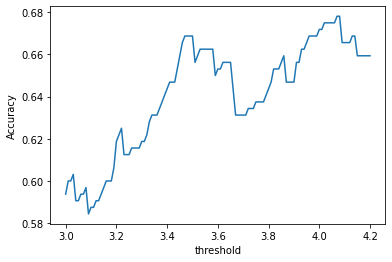

In [25]:
plt.plot(x, y)
plt.ylabel("Accuracy")
plt.xlabel("threshold")
plt.show()

The threshold of 4.1 maximises the accuracy of the method.

### 4.4. Rule C : Color<a class="anchor" id="Rule-C:-color"></a>
The first method that we will test is the one used in the paper [2]. This method consists in:
1. For each pixel in the lesion, calculate the normalized euclidian distance to the six suspicious colors, i.e white, black, red, dark-brown, light-brown and blue gray.
2. The pixel is said to belong to a color if the distance is smaller than a threshold. The threshold used in general is 0.4, since it is the normalised Euclidean distance between the black and white colors.
3. If the lesion contains at least 5% of a suspicious color, the lesion has a high chance to be a melanoma.

First, we extract the lesion in RGB color space.


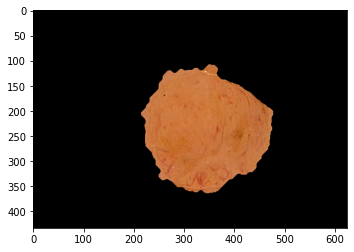

In [26]:
original, gray, final_mask = identify_hairs("ph2-dataset/IMD010.bmp", plotting=False, save=False)
removed = remove_hair(original, final_mask, plotting=False)
# preprocess the image
processed_image = melonoma_identification(removed)
final = removed.copy()
#get the RGB version of the lesion
R,G,B = removed[:,:,0], removed[:,:,1], removed[:,:,2]
final[:,:,0] = processed_image * R
final[:,:,1] = processed_image * G
final[:,:,2] = processed_image * B
plt.imshow(final, cmap="gray")
plt.show()

Then we apply the following algorithm :
1. We define the RGB of the six suspicious colors we are interested in.
2. we normalise the RGB values of these colors.
3. for each pixel in the lesion, we compute the normalised Euclidian distance between the pixel and the six colors.
4. We then compute the percentage of pixels that belong to a color. The percentages are stored in an array corresponding to this order [white, black, red, light-brown, dark-brown, blue-gray].

In [27]:
label_img = label(processed_image)
regions = regionprops(label_img)
coord = regions[0].coords

#define the rgb bands of the suspicious colors
l = [[255, 255, 255], [1, 1, 1], [255, 0, 0], [196, 164, 132], [101, 67, 33],[40, 60, 80]]
#normalize the rgb bands
l_norm = list(map(lambda x: x/np.linalg.norm(x), l))
binary = np.zeros(6)
#compute the normalized euclidean distance between the rgb bands and the suspicious colors
for i in range(len(coord)):
    a = final[coord[i][0],coord[i][1]]
    a = a / np.linalg.norm(a)

    new_x = list(map(lambda x: np.linalg.norm(a - x), l_norm))
    m = np.argmin(new_x)
    temp = np.zeros(6)
    if new_x[m] < 0.1:
        temp[m] = 1
    binary += temp

print(np.round(100 * binary/len(coord),2))


[0.000e+00 0.000e+00 0.000e+00 1.000e-02 9.009e+01 0.000e+00]


For the image above we obtain the higher percentage for dark-brown color.

Even if the lesion above is not a melanoma, using this method, it will be classified as one. Thus, we think that color suspicion using only this method is not a very good indicator of melanoma.

The method that will be used for color evaluation is the classical one that relies on the global standard deviations of the RGB values. Only this time it will be used on the legion only and not all the image as in the very first method of this notebook.

In [28]:
# compute the standard deviations of the each band
only_lesion = []
for c in coord:
    only_lesion.append(original[c[0],c[1]])
only_lesion = np.array(only_lesion)
R_std = np.std(only_lesion[:, 0])
G_std = np.std(only_lesion[:, 1])
B_std = np.std(only_lesion[:, 2])
#sum all the standard deviations
global_std = R_std + G_std + B_std
global_std

28.28267589993549

For the image above the score obtained is $28.28$. But without a reference, we cannor really know if this is score qualifies the lesion to be a melanoma or not. So we will use a threshold that is calculated using an iterative process on all the dataset. We will start with a threshold of $30$ and we will increase it until we find the threshold that maximises the accuracy.

In [29]:
GROUND_TRUTH = pd.read_csv("PH2_dataset.csv")


x = []
y = []
POSITIVES = 40
NEGATIVES = 160
stds = []
# compute the global standard deviations in the lesion for all the dataset
for j, element in enumerate(GROUND_TRUTH["Image Name"]):
    original = imread("ph2-dataset/"+GROUND_TRUTH["Image Name"][j]+".bmp")
    processed_image = melonoma_identification(original)
    label_img = label(processed_image)
    regions = regionprops(label_img)
    # get coordinates of the region
    coord = regions[0].coords
    only_lesion = []
    for c in coord:
        only_lesion.append(original[c[0],c[1]])
    only_lesion = np.array(only_lesion)
    R_std = np.std(only_lesion[:, 0])
    G_std = np.std(only_lesion[:, 1])
    B_std = np.std(only_lesion[:, 2])

    global_std = R_std + G_std + B_std
    stds.append(global_std)


The method is wrapped in a function for future use in the optimisation section.

In [30]:
def compute_C(image):
    image = imread(image)
    image = rgb2gray(image)
    processed_image = np.where(image > 0, 1, 0)
    label_img = label(processed_image)
    regions = regionprops(label_img)
    coord = regions[0].coords
    only_lesion = []
    for c in coord:
        only_lesion.append(original[c[0],c[1]])
    only_lesion = np.array(only_lesion)
    R_std = np.std(only_lesion[:, 0])
    G_std = np.std(only_lesion[:, 1])
    B_std = np.std(only_lesion[:, 2])

    global_std = R_std + G_std + B_std

    return global_std



In [31]:
x, y = [], []
# iterative process to find the optimal threshold by comparing the predicted values and ground truth
for i in np.arange(1,120,1):
    TP = 0
    TN = 0
    x.append(i)
    for j, s in enumerate(stds):
        if s > i:
            prediction = "Melanoma"
        else:
            prediction = "Non-Melanoma"

        if GROUND_TRUTH["Melanoma"][j] == 'X' and prediction == "Melanoma":
            TP+=1
        elif GROUND_TRUTH["Melanoma"][j] != 'X' and prediction == "Non-Melanoma":
            TN+=1

    accuracy = np.mean([TP/POSITIVES, TN/NEGATIVES])
    y.append(accuracy)


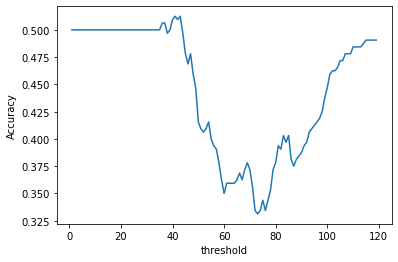

In [32]:
plt.plot(x, y)
plt.ylabel("Accuracy")
plt.xlabel("threshold")
plt.show()

As we can see, the threshold of 45 maximises the accuracy of the method. if the global standard deviation of the RGB values is higher than this value, we will consider that the lesion is a melanoma.

The thresholds that were found above will not be considered in the combination of the 4 rules, since we will be using weights that will be optimized in order to maximize the accuracy of the final method. More details in the next section.

### 4.5. Rules combination <a class="anchor" id="Rules-combinations"></a>
To combine the rules we will use the following score function :
$$ \text{score} = \sum_{i=0}^{n} \alpha_i c_i $$
Where $\alpha_i$ are the weights of the rules and $c_i$ are the scores (centralized and reduced) that we  computed from ABCD rules.

Then to predict the melanoma we will use the following binary operation :
$$ \text{prediction} = \text{score} \geq 1 $$ 
The prediction is 1 if the our program is confident enough to predict a melanoma and 0 otherwise.

We will try to find of the wheights $\alpha_i$ that maximize the accuracy of our model. First let define the accuracy :



In [33]:
def accuracy(coeffs, criterias, reality):
    """Compute the accuracy for a set of coefficients.

    Args:
        coeffs ([list of floats]): [list of coefficients]
        criterias ([list of 1xN ndarray]): [lists des differents scores pour chaque image et chaque critere]
        reality ([ndarray 1xN bool]): [true if malanoma is cancerous false if not]

    Returns:
        [float]: [accuracy = 0.5(TP/P + TN/N)]
    """    
    P = 40  # Positives number
    N = 160  # Negatives number

    TP = np.zeros_like(reality)  # True positives
    TN = np.zeros_like(reality)  # True negatives

    # Compute the scores through the array of criteria evaluation of each image
    scores = coeffs[0]*criterias[0] + coeffs[1] * \
        criterias[1] + coeffs[2]*criterias[2] + coeffs[3]*criterias[3] + coeffs[4]*criterias[4] + coeffs[5]*criterias[5]
    
    # Compute the true positives and true negatives arrays
    TP = np.logical_and(scores > 1, reality)
    TN = np.logical_and(scores <= 1, np.logical_not(reality))
    # Converts the arrays to integers
    TP = np.sum(TP)
    TN = np.sum(TN)
    # Compute the accuracy and returns it
    accuracy = 0.5*(TP/P + TN/N)
    return accuracy

Then we tried to perform a simple gradient descent on the weights $\alpha_i$. We will start with a random value and we will try to maximize the accuracy. However since this function accuracy is defined by portions (a very small variation is not enough to change the number of detected melanomas) it has not been successful.
Then we have developped a fucntion to perform the optimisation of the weights.
1. Create a x,y,z,t, ... , i, j grid (multidimensionnal dimmensionnal) of the weights values : 1 dimension is added for each new weight. Each axis is defined by a range of values containing the values that the weight will try to take.
2. For each set of weights, we will compute the accuracy of the model.
3. Grab the maximum accuracy and the corresponding weights.


In [34]:
# --- Algorithm to optimize the coefficients applied to each criteria ---
def optimize(criterias, positives, N=7):
    # N = 40  # Each axis length
    N_coeffs = len(criterias)  # Number of coefficients == dimensions of the space
    axis = np.linspace(-5, 5, N)

    grid = np.meshgrid(*[axis for i in range(N_coeffs)])

    acc = np.zeros([N for i in range(N_coeffs)])


    print(f'Total iterations to complete : {N**N_coeffs}')
    # Compute the accuracy for each point on the grid i.e a unique set of coefficients 
    for indexes in tqdm(np.ndindex(acc.shape)):
        coef = [ax.item(*indexes) for ax in grid]
        acc[indexes] = accuracy(coef, criterias, positives)

    # --- Extract the best accuracy and its corresponding coefficients ---
    index = np.unravel_index(np.argmax(acc, axis=None), acc.shape)
    coeffs = [ax.item(*index) for ax in grid]
    print(f"coeffs={coeffs}")
    acc = acc[index]
    print(f"acc={acc}")
    return coeffs, acc



Then use this method on the computed scores we obtained from the ABCD rules.
- Note that since one axis is added for each new weight, time explosion is possible for too many weights.
- We can compute the number of iterations with the following formula, let $N$ be the number points in each grid direction and $M$ the number of weights : 
$$ \text{it}  = N^M $$

In [36]:
# --- For each image compute its scores and store them---
# Empty lists to store the scores
A_scores_color = []
A_scores_luminance = []
A_scores_area = []
D_scores = []
B_scores = []
C_scores = []
files = os.listdir('./ph2-dataset/')

# Loop through all the images and computes their scores
for f in tqdm(os.listdir('ph2-processed/')):
    score_color, score_luminance, score_area, score_diameter = compute_AD_criteria(
        'ph2-processed/'+f)
    A_scores_color.append(score_color)
    A_scores_luminance.append(score_luminance)
    A_scores_area.append(score_area)
    D_scores.append(score_diameter)
    B_scores.append(compute_B('ph2-processed/'+f))
    C_scores.append(compute_C('ph2-processed/'+f))


# --- Standardize the scores ---
A_scores_color = np.array(A_scores_color)
A_scores_luminance = np.array(A_scores_luminance)
A_scores_area = np.array(A_scores_area)
D_scores = np.array(D_scores)
A_scores_color,Mac,Sac = centree_reduite(A_scores_color)
A_scores_luminance,Mal,Sal = centree_reduite(A_scores_luminance)
A_scores_area,Maa, Saa = centree_reduite(A_scores_area)
D_scores, Md,Sd = centree_reduite(D_scores)
B_scores, Mb,Sb= centree_reduite(B_scores)
C_scores, Mc,Sc= centree_reduite(C_scores)

# --- Save the scores into a csv file ---
# load the dataset containing the ground truth
GROUND_TRUTH = pd.read_csv("PH2_dataset.csv")
# create a dataframe containing the scores to save
df = pd.DataFrame({
    'file': files,
    'positive': GROUND_TRUTH["Melanoma"].values == 'X',
    'A_color_score': A_scores_color,
    'A_luminance_score': A_scores_luminance,
    'A_area_score': A_scores_area,
    'D_score': D_scores,
    'B_score': B_scores,
    'C_score': C_scores,
})
# saving
df.to_csv('optimize.csv', index=False)

storage_order = ['A color', 'A luminance', 'A area', 'B', 'C', 'D']
S = [Sac, Sal, Sac, Sb, Sc, Sd]
M = [Mac, Mal, Mac, Mb, Mc, Md]
df = pd.DataFrame({
    'order' : storage_order,
    'S' : S,
    'M' :M
})
df.to_csv('centree_reduite.csv', index=False)

100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


In [37]:
# --- Load the dataset criterias and extract values ---
# Load
df = pd.read_csv('optimize.csv')
# Extract
A_criteria_color = df['A_color_score'].values
A_criteria_luminance = df['A_luminance_score'].values
A_criteria_area = df['A_area_score'].values
B_criteria = df['B_score'].values
C_criteria = df['C_score'].values
D_criteria = df['D_score'].values
criterias = [A_criteria_color, A_criteria_luminance,
             A_criteria_area, B_criteria, C_criteria, D_criteria]
positives = df['positive'].values

# --- Optimize the coefficients ---
coeffs, acc = optimize(criterias, positives)

Total iterations to complete : 117649


117649it [00:04, 28962.34it/s]

coeffs=[5.0, -1.6666666666666665, 5.0, 5.0, 0.0, 5.0]
acc=0.85625


Then finally we can predict melanomas using the following function : 
- Note that it requires the standard deviation and mean of each criteria

In [44]:
def predict_melanoma(image,coeffs):
    """
    Predict whether an image is a melanoma or not.
    """
    # Compute the scores

    df = pd.read_csv('centree_reduite.csv')
    score_color, score_luminance, score_area, score_diameter = compute_AD_criteria(
        image)
    score_B = compute_B(image)
    score_C = compute_C(image)
    
    # Standardize the scores
    score_color = (score_color-df['M'][0])/df['S'][0]
    score_luminance = (score_luminance-df['M'][1])/df['S'][1]
    score_area = (score_area-df['M'][2])/df['S'][2]
    score_B = (score_B-df['M'][3])/df['S'][3]
    score_C = (score_C-df['M'][4])/df['S'][4]
    score_D = (score_diameter-df['M'][5])/df['S'][5]

    # Compute the scores
    score = coeffs[0]*score_color + coeffs[1] * \
        score_luminance + coeffs[2]*score_area + coeffs[3]*score_diameter + coeffs[4]*score_B + coeffs[5]*score_C

    # Return the prediction
    if score > 1:
        return True
    else:
        return False

predict_melanoma('ph2-processed/IMD008.bmp',coeffs)

True

For a set of 3 $\alpha_i$ using the previous method it is possible to find create a plot representing the accuracy of the model for each $\alpha_i$ $(x,y,z)$ here and in color the accuracy of a point set. It can be seen that the 

  
<img src="optimiisation.png" style="text-align:center" alt="drawing" width="600"/>

For the real case we will have more than 3 $\alpha_i$ so it will not be possible to plot the accuracy model since it will be too complex (dimensions > 3).

#### Review rules combination
- With this we reached a precision of about $\simeq 0.82\%$ on the whole dataset. This is a quite good result considering the fact that we have only a small number of images.
- Moreover, this optimization method seems correct, still it is not the best method. It will struggle for a large number of weights. And the higher the number of weights the more robust results will be obtained, so this method requires improvements.
- Next step would be to test the programm on a test dataset to see if it is able to predict the lesion correctly with the stored since the weights are optimized for this dataset.


## 5. Conclusion <a class="anchor" id="Conclusion"></a>
In notebook we used severals image processing features to implement a real case world usage of image processing. We can see that even with basic notions, we learned
in few weeks that it is possible to obtain interesting results. We learned a lot from this project, and also had the occasion to go through several research papers from which we learned how image processing is used to solve medical problems, and how scientific reasoning works. 


Image processing is a process that allows extraction of information from an image, yet with the current boom of AI, new ways of information extraction from images are used, which are not available in classical image processing. However, it is also possible to use these new methods along with the classical image processing to perform pre-processing and post-processing along with each other to even improve the robustness and the accuracy. For instance, for our case, one could have used image processing to extract specific information about the lesion, such as the shape, the color, the texture, the size, etc. This information could be used to perform a more accurate classification of the lesion using deep learning for example.



## 6. References <a class="anchor" id="References"></a>
1. Abbas, Q., Celebi, M. E., & García, I. F. (2011). Hair removal methods: A comparative study for dermoscopy images. Biomedical Signal Processing and Control, 6(4), 395-404.
2. Kasmi, R., & Mokrani, K. (2016). Classification of malignant melanoma and benign skin lesions: implementation of automatic ABCD rule. IET Image Processing, 10(6), 448-455.
3. Lee, T. K., McLean, D. I., & Stella Atkins, M. (2003). Irregularity index: A new border irregularity measure for cutaneous melanocytic lesions. In Medical Image Analysis (Vol. 7, Issue 1, pp. 47–64). Elsevier BV. https://doi.org/10.1016/s1361-8415(02)00090-7
4. Wikipedia contributors. (2021, November 23). Sensitivity and specificity. Wikipedia. https://en.wikipedia.org/wiki/Sensitivity_and_specificity